# Class-Activation-Maps with PyTorch and a ResNet model

- Author: Marc Aubreville (www5.cs.fau.de/~aubreville)




- Inspired by: 
    - Zhou, B., Khosla, A., Lapedriza, À., Oliva, A., & Torralba, A. (2016). Learning deep features for discriminative localization (pp. 2921–2929). Presented at the Proceedings of the IEEE conference on computer vision and pattern recognition.
    - Pierre Guillou's article on inference: https://medium.com/@pierre_guillou/deep-learning-web-app-by-fastai-v1-3ab4c20b7cac


## Objective

Showing how Class Activation Maps work using pre-trained ResNet-18 from the Torch model zoo.

## Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import nn as nn
from torchvision import *
import matplotlib.pyplot as plt
#from fastai.vision import *
#from fastai.widgets import *
import cv2
import json
import numpy as np

## Get the ImageNet classes

In [3]:
classes =  json.load(open('imagenet_classes.json'))

In [4]:
classes[:10]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus']

In [5]:
# Keep the first label by class
classes = [classes[i].split(',', 1)[0] for i in range(len(classes))]

In [6]:
classes[:10]

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

## Model

Let's use resnet18.

In [7]:
# Get weights of the model and add nn.LogSoftmax(dim=1) to the end
model_name = 'resnet18'
model = models.resnet18(pretrained=True)
model = nn.Sequential(model, nn.LogSoftmax(dim=1))


### Now, let us derive a ResNet18 model where we convert the last FC layer to a 1x1 convolution and skip the GAP layer

In [8]:
res18_model = models.resnet18(pretrained=True)
#res18_conv = nn.Sequential(*list(res18_model.children())[:-2])

fc = res18_model.fc.state_dict()

in_ch = 512
out_ch = fc["weight"].size(0)
finalConv = nn.Conv2d(in_ch, out_ch, 1, 1)

### get the weights from the fc layer
finalConv.load_state_dict({"weight":fc["weight"].view(out_ch, in_ch, 1, 1),
                           "bias":fc["bias"]})
res18_conv = nn.Sequential(*list(res18_model.children())[:-2]+[finalConv])

res18_model.eval()
res18_conv.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

## Data to classify

In [9]:
# List of images to classify
images = [
          ('cat', 'images/mogli.jpg'),
          ('dog', 'images/nero.jpg'),
          ('cat', 'images/balu.jpg')
         ]

## Get the 3 best predictions

In [10]:
import torchvision.transforms as transforms
from fastai import *
from matplotlib import cm
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

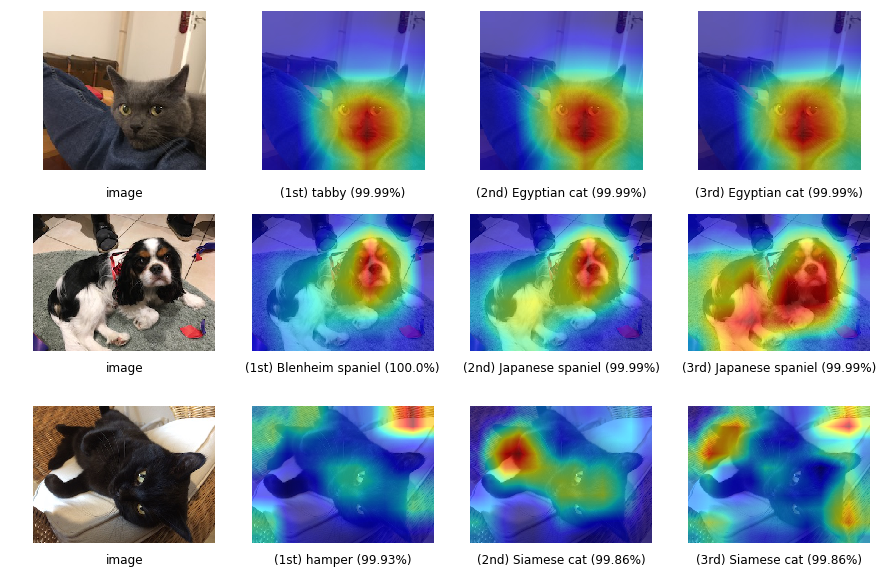

In [11]:
from PIL import Image as PILImage
fig, ax = plt.subplots(3,4,figsize=(15,10))

for i, image in enumerate(images):

    class_name, img_url = image[0], image[1]

    img_pil = PILImage.open(img_url)

    # Get best first prediction
    
    img = torch.from_numpy(np.float32(np.array(img_pil))/255.).permute(2,0,1)
    
    im = transforms.Normalize(imagenet_stats[0],imagenet_stats[1])(img)

    with torch.no_grad():
        preds = res18_model(im[None,:,:,:])[0].sigmoid()
        cam = res18_conv(im[None,:,:,:])

    preds_sorted, idxs = preds.sort(descending=True)
    
    # Get best 3 predictions - classes
    pred_1_class = classes[idxs[0]]
    pred_2_class = classes[idxs[1]]
    pred_3_class = classes[idxs[2]]
    
    # Get best 3 predictions - probabilities
    pred_1_prob = np.round(100*preds_sorted[0].item(),2)
    pred_2_prob = np.round(100*preds_sorted[1].item(),2)
    pred_3_prob = np.round(100*preds_sorted[2].item(),2)
    preds_best3 = [f'{pred_1_class} ({pred_1_prob}%)', f'{pred_2_class} ({pred_2_prob}%)', f'{pred_3_class} ({pred_3_prob}%)']
    
    
    cam1 = cv2.resize(np.array(cam[0,idxs[0]]), dsize=(img.shape[2],img.shape[1]))
    cam2 = cv2.resize(np.array(cam[0,idxs[1]]), dsize=(img.shape[2],img.shape[1]))
    cam3 = cv2.resize(np.array(cam[0,idxs[2]]), dsize=(img.shape[2],img.shape[1]))



    ax[i,0].imshow(np.asarray(img_pil))
    ax[i,1].imshow(np.asarray(img_pil))
    ax[i,2].imshow(np.asarray(img_pil))
    ax[i,3].imshow(np.asarray(img_pil))



    ax[i,0].axis('off')
    ax[i,1].axis('off')
    ax[i,2].axis('off')
    ax[i,3].axis('off')



    
    img_pil.show()
    ax[i,0].set_title('image', y=-0.2)
    ax[i,1].set_title(f'(1st) {preds_best3[0]}', y=-0.2)
    ax[i,2].set_title(f'(2nd) {preds_best3[1]}', y=-0.2)
    ax[i,3].set_title(f'(3rd) {preds_best3[1]}', y=-0.2)


    im = ax[i,1].imshow(cam1, alpha=0.6, cmap=cm.jet)    
    im = ax[i,2].imshow(cam2, alpha=0.6, cmap=cm.jet)    
    im = ax[i,3].imshow(cam3, alpha=0.6, cmap=cm.jet)    



plt.savefig('CAM.svg')
plt.savefig('CAM.pdf')